<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">

### Image Classification using ResNet101

This Code Template is for simple image classification using Resnet101. ResNets are one of the most efficient Neural Network Architectures, as they help maintain a low error rate much deeper in the network. 

### Required Packages

In [28]:
import os
import numpy as np
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
from PIL import Image
from tqdm.notebook import tqdm
from glob import glob
from torchsummary import summary
import warnings
warnings.filterwarnings('ignore')

# PyTorch Modules
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### Initialization
Path of the main folder containing train and test folders

In [ ]:
BASE_DIR = ''
print(os.listdir(BASE_DIR))

Path of the train and test folders containing image files

In [3]:
train_dir = os.path.join(BASE_DIR, 'train') #train
test_dir = os.path.join(BASE_DIR, 'test') #test

List of target categories which are required for model training and predictions.

In [4]:
target = []

In [ ]:
print(len(target))

### Directory Structure
The OS module in Python provides functions for interacting with the operating system. This module provides a portable way of using operating system-dependent functionality.
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>Master Directory</b>
 |__<b>train</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
 |__<b>test</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
</pre>

In [6]:
# useful for getting number of files
train_image_files = glob(train_dir + '/*/*.jp*g')
test_image_files = glob(test_dir + '/*/*.jp*g')

### Data Preprocessing (normalization & data augmentation)

Transforms are common image transformations. They can be chained together using Compose. Most transform classes have a function equivalent: functional transforms give fine-grained control over the transformations. This is useful if you have to build a more complex transformation pipeline.

1. **Resize**:
>Resize the input image to the given size. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions
- Class
          torchvision.transforms.Resize(size, interpolation=<InterpolationMode.BILINEAR: 'bilinear'>, max_size=None, antialias=None)

2. **RandomCrop**:
> Crop the given image at a random location. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions, but if non-constant padding is used, the input is expected to have at most 2 leading dimensions
- Class
          torchvision.transforms.RandomCrop(size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant')

3. **RandomHorizontalFlip**:
>Horizontally flip the given image randomly with a given probability. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions
- Class 
          torchvision.transforms.RandomHorizontalFlip(p=0.5)

4. **RandomRotation**: 
> Rotate the image by angle. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions.
- Class
      torchvision.transforms.RandomRotation(degrees, interpolation=<InterpolationMode.NEAREST: 'nearest'>, expand=False, center=None, fill=0, resample=None)

5. **ColorJitter**:	 
>Randomly change the brightness, contrast, saturation and hue of an image. If the image is torch Tensor, it is expected to have […, 3, H, W] shape, where … means an arbitrary number of leading dimensions. If img is PIL Image, mode “1, “L, “I, “F and modes with transparency (alpha channel) are not supported.
- Class
      torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)


6. **ToTensor**:
>Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.
- Class 
      torchvision.transforms.ToTensor

7. **RandomPerspective**: 
>Performs a random perspective transformation of the given image with a given probability. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions.
- Class
      torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=<InterpolationMode.BILINEAR: 'bilinear'>, fill=0)

8. **Normalize**:
>Normalize a tensor image with mean and standard deviation. This transform does not support PIL Image. Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e., output[channel] = (input[channel] - mean[channel]) / std[channel]
- Class
      torchvision.transforms.Normalize(mean, std, inplace=False)


For more information, refer to this [API](https://pytorch.org/vision/stable/transforms.html)

In [8]:
imagenet_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # mean and std of imagenet

train_tfms = T.Compose([ 
                            T.Resize(225),
                            T.RandomCrop(224),
                            T.RandomHorizontalFlip(), 
                            T.RandomRotation(degrees=(-45, 45)),
                            T.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
                            T.ToTensor(),
                            T.RandomPerspective(distortion_scale=0.2, p=0.5),
                            T.Normalize(*imagenet_stats, inplace=True)])

val_tfms = T.Compose([
                        T.Resize(225),
                        T.CenterCrop(224), 
                        T.ToTensor(),
                        T.Normalize(*imagenet_stats)])

### Creating Pytorch Datasets Using ImageFolder and Dataloader 

In [9]:
# PyTorch datasets
train_ds = ImageFolder(train_dir, train_tfms)
valid_ds = ImageFolder(test_dir, val_tfms)

In [10]:
print(len(train_ds))
print(len(valid_ds))

14630
1500


#### Creating Train and Validation Dataloaders

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

For more information, refer [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [12]:
batch_size = 64 # number of images to process at a time 

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

### Display a Grid of Augmented Data

In [11]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means


In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


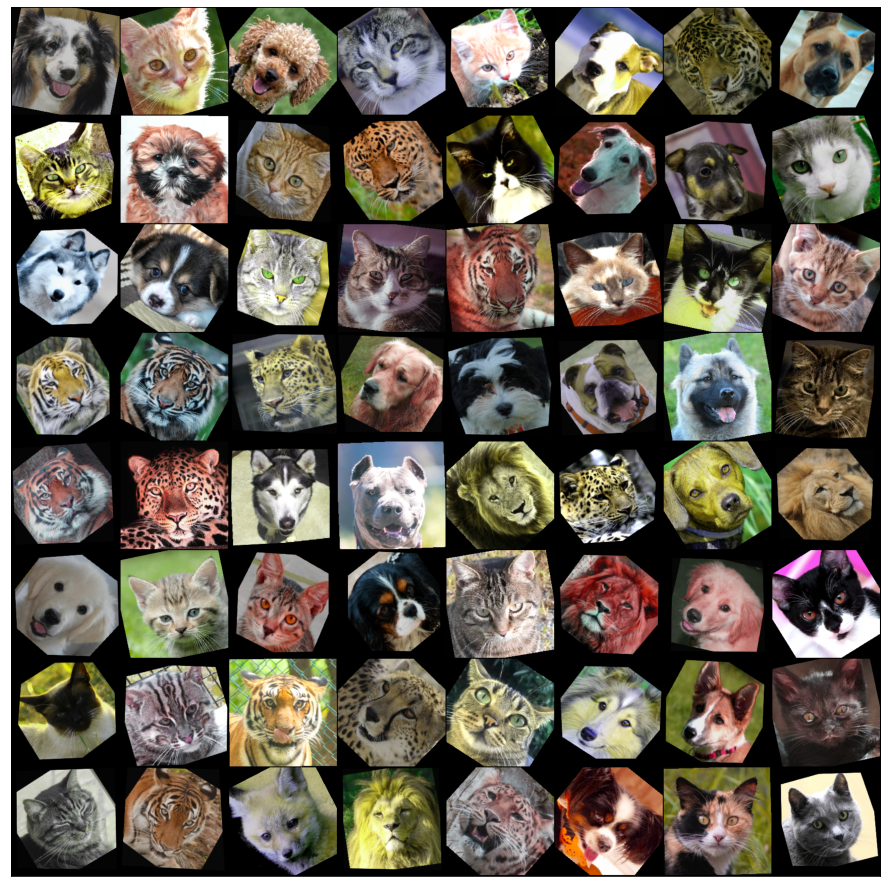

In [14]:
show_batch(train_dl)

### Modifying a Pretrained Model (ResNet101)

Transfer learning :

![transfer-learning](https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png)


ImageClassificationBase is a custom class which contains helper methods for training & validation.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


### Model

Resnet models were proposed in “Deep Residual Learning for Image Recognition. Here we have the 5 versions of resnet models, which contains 18, 34, 50, 101, 152 layers respectively
* torchvision.models.resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) → torchvision.models.resnet.ResNet
> Parameters

    - pretrained (bool) : If True, returns a model pre-trained on ImageNet
    - progress (bool) : If True, displays a progress bar of the download to stderr

ResNet-101 model from [“Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf).

For more information on Pretrained models in Pytorch, refer [here](https://pytorch.org/vision/stable/models.html#)

In [16]:
class ResnetModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet101(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

## GPU Utilities and Training Loop

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [18]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Finetuning the Pretrained Model

In [21]:
model = ResnetModel(len(target))
to_device(model, device)

In [38]:
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [24]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.3584975004196167, 'val_loss': 1.171295166015625}]

In [34]:
# Hyperparameters
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

# Training Cycle with Learning Rate Scheduler

In [35]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00759, train_loss: 0.2753, val_loss: 0.9695, val_acc: 0.7091


  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00950, train_loss: 0.3072, val_loss: 0.1719, val_acc: 0.9373


  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00611, train_loss: 0.2039, val_loss: 0.6937, val_acc: 0.8413


  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00188, train_loss: 0.1232, val_loss: 0.1104, val_acc: 0.9562


  0%|          | 0/229 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00000, train_loss: 0.0601, val_loss: 0.0460, val_acc: 0.9835
CPU times: user 21min 7s, sys: 19min 57s, total: 41min 5s
Wall time: 43min 9s


# Plots

Plot loss, accuracy metrics and learning rates to see how the model trains

In [38]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [39]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [40]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

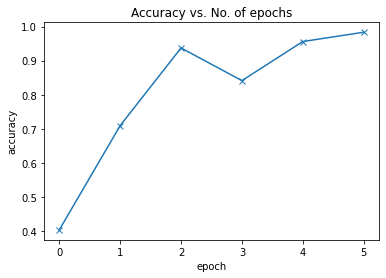

In [41]:
plot_accuracies(history)

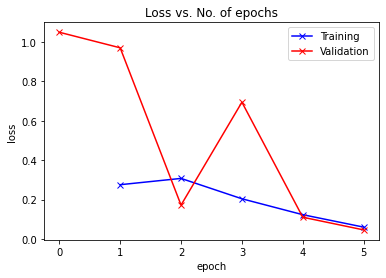

In [42]:
plot_losses(history)

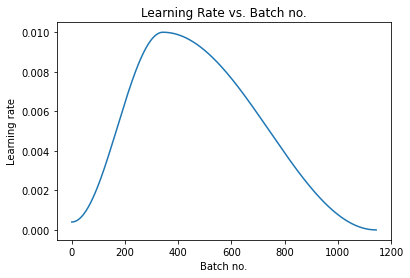

In [43]:
plot_lrs(history)

### Model Evaluation (Accuracy)

In [23]:
result = evaluate(model, valid_dl)
print('Loss : ', result['val_loss'])
print('Accuracy : ', result['val_acc'])

Loss :  0.04600831866264343
Accuracy :  0.9834974408149719


### Confusion Matrix

A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

In [32]:
def get_confusion_matrix(data, N):
  print("Generating confusion matrix", N)
  with torch.no_grad():
    predictions = []
    targets = []
    i = 0
    for x, y in data:
      i += 1
      if i % 50 == 0:
        print(i)

      # transfer image to gpu if available
      x = to_device(x, device)
      # Get predictions from model
      p = model(x)
      # Pick index with highest probability
      _, y_pred  = torch.max(p, dim=1)

      predictions = np.concatenate((predictions, y_pred))
      targets = np.concatenate((targets, y))

      if len(targets) >= N:
        break
    cm = confusion_matrix(targets, predictions)
    
  return predictions,targets,cm

In [33]:
y_pred, y_target, cm = get_confusion_matrix(valid_dl, len(test_image_files))

Generating confusion matrix 1500


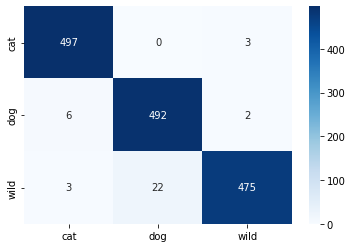

In [35]:
sns.heatmap(cm,
            annot = True,
            fmt = 'd',
            xticklabels=target, 
            yticklabels= target,
            cmap = plt.cm.Blues)
plt.show()

### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.

* **where**:
    - Precision:- Accuracy of positive predictions.
    - Recall:- Fraction of positives that were correctly identified.
    - f1-score:-  percent of positive predictions were correct
    - support:- Support is the number of actual occurrences of the class in the specified dataset.

In [34]:
print(classification_report(y_target, y_pred, target_names=target))

              precision    recall  f1-score   support

         cat       0.98      0.99      0.99       500
         dog       0.96      0.98      0.97       500
        wild       0.99      0.95      0.97       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



#### Creator: Vamsi Mukkamala , Github: [Profile](https://github.com/vmc99)